# Next Subway Data Analysis

Covers spatial analysis of multiple transportation modes

This notebook was run on Python 3.7

In [40]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely.geometry
from shapely.geometry import Point, Polygon, LineString
import urllib
from descartes import PolygonPatch
import zipfile
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [399]:
#Define subfolders.  Customize as needed
boundaryFolder = 'Borough Boundaries/'
tractsFolder = 'Tracts/'
cbFolder='CitiBike/'

Define Geographic Boundary

In [384]:
#Data obtained by searching NYC Borough Boundaries on open data portal 
#or at https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
nyc = gpd.read_file(boundaryFolder+'geo_export_663c4f84-8c5e-4d7e-8346-d3dd3ec4b74f.shp')

In [386]:
#Staten Island not included in this analysis
nyc = nyc.loc[(nyc.boro_code!=5)].copy()

In [387]:
nyc

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.187231e+09,464720.015850,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
2,4.0,Queens,3.042318e+09,903938.441308,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
3,1.0,Manhattan,6.366055e+08,359935.015632,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."


<AxesSubplot:>

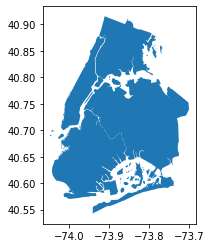

In [165]:
nyc.plot()

## Census Tracts

In [44]:
#Shapefile for most recent census tracts pre-2020 found here: https://geo.nyu.edu/catalog/nyu-2451-34505
tracts = gpd.read_file(tractsFolder + 'nyu_2451_34161.shp')

In [236]:
tracts.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [45]:
tracts = tracts.to_crs('epsg:4326')

In [390]:
tracts['TractID'] = pd.to_numeric(tracts['CTLABEL'],errors='coerce')
tracts['TractID'] = 100 * tracts['TractID']
tracts['TractID'] = tracts['TractID'].astype(str)+tracts.BOROCODE.astype(str).copy()
#tracts['TractID'] = tracts['TractID'].astype(int)
tracts.head(2)

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300.04
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401.04


# Citi Bike

In [ ]:
# Citibike data available here: https://s3.amazonaws.com/tripdata/index.html

In [71]:
##Can comment out after first run
def unzipFiles(cbFolder):
    files=os.listdir(cbFolder)
    for file in files:
        if file.endswith('.zip'):
            filePath=cbFolder'+file
            zip_file = zipfile.ZipFile(filePath)
            for names in zip_file.namelist():
                zip_file.extract(names,cbFolder)
            zip_file.close() 

In [72]:
##Can comment out after first run
unzipFiles(cbFolder)

In [47]:
folder = cbFolder
files = [folder+'201901-citibike-tripdata.csv',
        folder+'201902-citibike-tripdata.csv',
        folder+'201903-citibike-tripdata.csv',
        folder+'201904-citibike-tripdata.csv',
        folder+'201905-citibike-tripdata.csv',
        folder+'201906-citibike-tripdata.csv',
        folder+'201907-citibike-tripdata.csv',
        folder+'201908-citibike-tripdata.csv',
        folder+'201909-citibike-tripdata.csv',
        folder+'201910-citibike-tripdata.csv',
        folder+'201911-citibike-tripdata.csv',
        folder+'201912-citibike-tripdata.csv']

In [48]:
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

In [49]:
cb = pd.concat(dfs)

In [52]:
#Filter out unreasonably short/long trips, as well as those that start and end in the same spot
cb = cb.loc[(cb.tripduration > (30))&(cb.tripduration<(3600*8))].copy()
cb = cb.loc[(cb['start station id']!=cb['end station id'])].copy()

In [152]:
cb.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,320,2019-01-01 00:01:47.4010,2019-01-01 00:07:07.5810,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.7360,2019-01-01 00:10:00.6080,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.9970,2019-01-01 00:15:55.4380,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,3154.0,E 77 St & 3 Ave,40.773142,-73.958562,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.5450,2019-01-01 00:52:22.6500,504.0,1 Ave & E 16 St,40.732219,-73.981656,3709.0,W 15 St & 6 Ave,40.738046,-73.996430,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.9450,2019-01-01 00:12:39.5020,229.0,Great Jones St,40.727434,-73.993790,503.0,E 20 St & Park Ave,40.738274,-73.987520,35379,Subscriber,1979,1


In [153]:
len(cb)

20095303

In [53]:
cb['count'] = np.zeros(len(cb))

In [54]:
cbRoutes = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id','end station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [55]:
len(cbRoutes)

394298

In [56]:
geometry = [Point(xy) for xy in zip(cbRoutes['start station longitude'], cbRoutes['start station latitude'])]
cbRoutesGeo = GeoDataFrame(cbRoutes, crs="EPSG:4326", geometry=geometry)

In [57]:
cbRoutesGeo = gpd.sjoin(nyc, cbRoutesGeo, op='intersects', how ='inner')


In [59]:
#Analyze manhattan on its own due to its high volumes
cbRoutesMn = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 1)].copy()
#No stations Bx found in this set
#cbRoutesBx = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 2)].copy()
cbRoutesBQ = cbRoutesGeo.loc[(cbRoutesGeo.boro_code == 3)|(cbRoutesGeo.boro_code == 4)].copy()

In [60]:
cbPopRoutesMn = cbRoutesMn.sort_values(by='count',ascending=False).head(100).copy()

In [61]:
cbPopRoutesBQ = cbRoutesBQ.sort_values(by='count',ascending=False).head(100).copy()

In [62]:
geometryO = [Point(xy) for xy in zip(cbPopRoutesMn['start station longitude'], cbPopRoutesMn['start station latitude'])]
geometryD = [Point(xy) for xy in zip(cbPopRoutesMn['end station longitude'], cbPopRoutesMn['end station latitude'])]
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
cbLinesMn = GeoDataFrame(cbPopRoutesMn , crs='epsg:4326', geometry = geometry)

In [63]:
geometryO = [Point(xy) for xy in zip(cbPopRoutesBQ['start station longitude'], cbPopRoutesBQ['start station latitude'])]
geometryD = [Point(xy) for xy in zip(cbPopRoutesBQ['end station longitude'], cbPopRoutesBQ['end station latitude'])]
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
cbLinesBQ = GeoDataFrame(cbPopRoutesBQ , crs='epsg:4326', geometry = geometry)

(-74.05478355924244, -73.89959706378299, 40.673110890352014, 40.88884410240033)

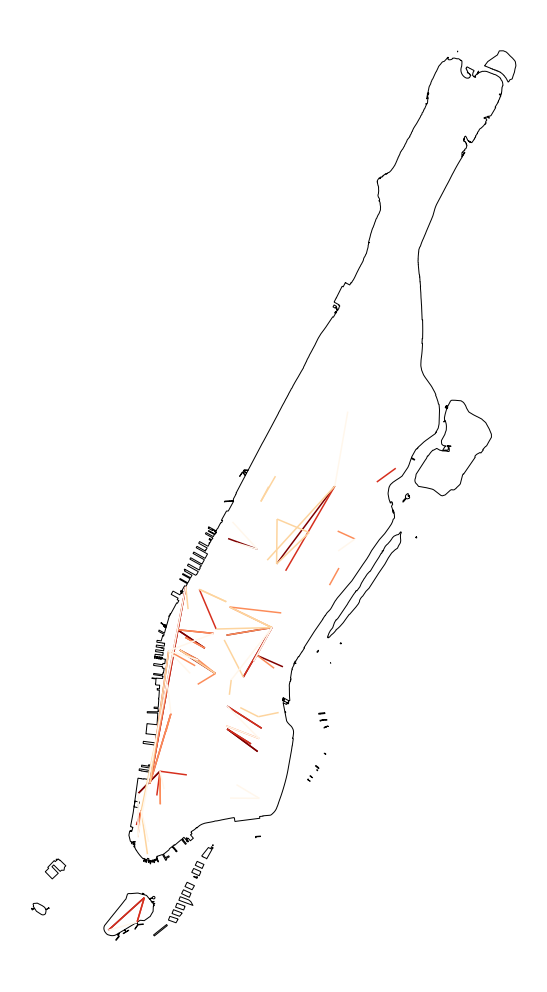

In [207]:
#Plot the 100 most popular O-D pairs 
ax = cbLinesMn.plot(markersize=.1, figsize=(18,18), column='count', cmap='OrRd', scheme = 'quantiles')
nyc.loc[nyc.boro_code==1].plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

(-74.05899080015885, -73.68291469547655, 40.528875085084806, 40.81397034318728)

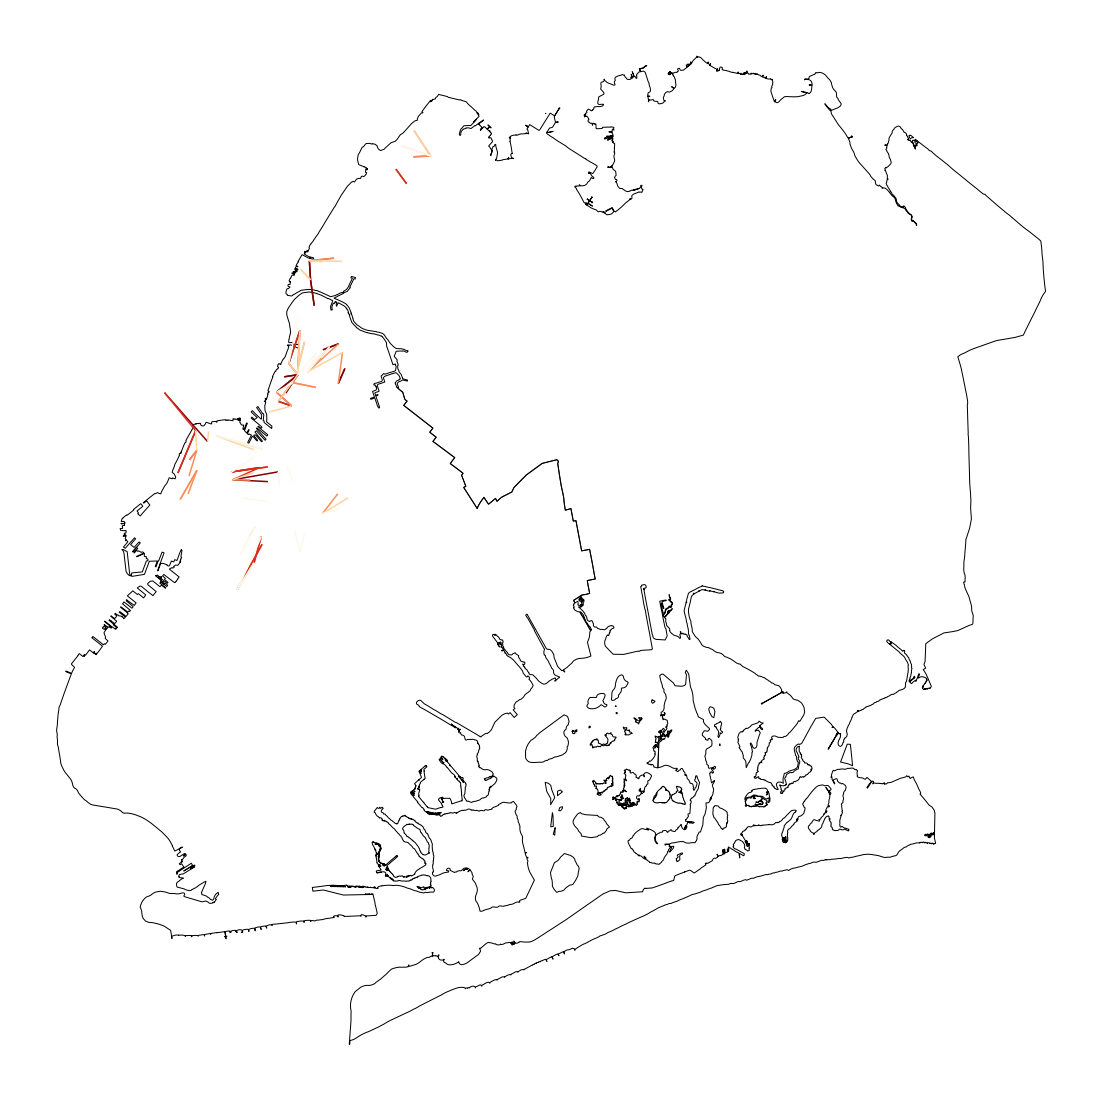

In [206]:
#Plot the 100 most popular citi bike trips that begin outside manhattan
ax = cbLinesBQ.plot(markersize = .5, figsize=(20,20), column='count', cmap='OrRd', scheme = 'quantiles')
nyc.loc[(nyc.boro_code.isin([3,4])==True)].plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

In [208]:
#Save shapefiles
cbLinesMn.to_file('cbLinesMn.shpe')
cbLinesBQ.to_file('cbLinesBQ.shpe')

## Citibike Demand

In [64]:
#Overall trips in an area
cbOrig = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [65]:
cbOrig.sort_values(by = 'count', ascending=False)

,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
start station id,,,,,,,
519.0,155511,Pershing Square North,40.751873,-73.977706,E 39 St & 2 Ave,40.747804,-73.973442
497.0,119932,E 17 St & Broadway,40.737050,-73.990093,E 16 St & Irving Pl,40.735367,-73.987974
3255.0,118982,8 Ave & W 31 St,40.750585,-73.994685,11 Ave & W 27 St,40.751396,-74.005226
402.0,111879,Broadway & E 22 St,40.740343,-73.989551,University Pl & E 8 St,40.731437,-73.994903
285.0,111669,Broadway & E 14 St,40.734546,-73.990741,Garfield Pl & 8 Ave,40.671198,-73.974841
...,...,...,...,...,...,...,...
3867.0,8,Somers St & Broadway,40.679450,-73.904740,Albany Ave & Fulton St,40.680011,-73.938475
3250.0,6,58th St Depot,40.716910,-73.983838,2 Ave & 36 St - Citi Bike HQ at Industry City,40.657089,-74.008702
3909.0,6,Madison St & Woodward Ave,40.704080,-73.904080,Lewis Ave & Madison St,40.686312,-73.935775


In [67]:
geometryO = [Point(xy) for xy in zip(cbOrig['start station longitude'], cbOrig['start station latitude'])]
cbOrigGeo = GeoDataFrame(cbOrig, crs="EPSG:4326", geometry=geometryO)

In [391]:
cbTracts = gpd.sjoin(tracts, cbOrigGeo, op='intersects', how='inner')

In [247]:
cbTracts.columns

Index(['CTLABEL', 'BOROCODE', 'BORONAME', 'CT2000', 'BOROCT2000', 'CDELIGIBIL',
       'PJAREACODE', 'PJAREANAME', 'PUMA', 'SHAPE_LENG', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry', 'TractID', 'index_right', 'count',
       'start station name', 'start station latitude',
       'start station longitude', 'end station name', 'end station latitude',
       'end station longitude'],
      dtype='object')

In [392]:
cbTracts = cbTracts.groupby(['TractID'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'}).copy()


In [393]:
cbTracts

,count,start station name,start station latitude,start station longitude,end station name,end station latitude,end station longitude
TractID,,,,,,,
100.03,3,Henry St & Middagh St,40.700300,-73.991581,State St & Smith St,40.689269,-73.989129
100.04,4,47 Ave & Skillman Ave,40.743752,-73.941765,5 St & 51 Ave,40.742374,-73.956600
10000.01,4,E 51 St & Lexington Ave,40.757148,-73.972078,8 Ave & W 52 St,40.763707,-73.985162
1002.01,1,Stanton St & Mangin St,40.717821,-73.976289,1 Ave & E 68 St,40.765005,-73.958185
10100.01,4,6 Ave & W 33 St,40.749013,-73.988484,W 43 St & 6 Ave,40.755273,-73.983169
...,...,...,...,...,...,...,...
9700.01,4,W 26 St & 8 Ave,40.747348,-73.997236,Gansevoort St & Hudson St,40.739448,-74.005070
9700.04,2,24 Ave & 26 St,40.774591,-73.918544,Crescent St & 30 Ave,40.768692,-73.924957
9800.01,4,E 51 St & 1 Ave,40.754557,-73.965930,1 Ave & E 18 St,40.733812,-73.980544


In [394]:
cbDemand = cbOrigGeo[['count','geometry']].copy()

In [395]:
tracts.head()

,CTLABEL,BOROCODE,BORONAME,CT2000,BOROCT2000,CDELIGIBIL,PJAREACODE,PJAREANAME,PUMA,SHAPE_LENG,SHAPE_AREA,SHAPE_LEN,geometry,TractID
0,43,4,Queens,004300,4004300,E,QN68,Qnsbridge-Ravenswd-LngIslCityN,4101,6401.411786,1.838665e+06,6401.411871,"POLYGON ((-73.93541 40.76350, -73.93398 40.762...",4300.04
1,44.01,4,Queens,004401,4004401,E,QN56,Ozone Park,4113,7561.021748,2.776681e+06,7561.021754,"POLYGON ((-73.85748 40.67817, -73.85687 40.676...",4401.04
2,44.02,4,Queens,004402,4004402,I,QN57,Lindenwood - Howard Beach,4113,5139.834810,1.065308e+06,5139.834769,"POLYGON ((-73.85655 40.67263, -73.85633 40.672...",4402.04
3,45,4,Queens,004500,4004500,I,QN70,Astoria,4101,7936.395515,2.371836e+06,7936.395385,"POLYGON ((-73.93225 40.76553, -73.93169 40.765...",4500.04
4,47,4,Queens,004700,4004700,E,QN70,Astoria,4101,5564.465823,1.929218e+06,5564.465936,"POLYGON ((-73.93158 40.76171, -73.93055 40.761...",4700.04


In [396]:
cbDemand = gpd.sjoin(tracts, cbDemand, op='intersects', how='inner')

In [397]:
cbDemand = cbDemand[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'})

In [398]:
cbDemand

,count,geometry
TractID,,
100.03,22517,"POLYGON ((-73.99126 40.70103, -73.99093 40.700..."
100.04,35015,"POLYGON ((-73.93726 40.74518, -73.93765 40.743..."
10000.01,65360,"POLYGON ((-73.96802 40.75958, -73.96848 40.758..."
1002.01,18760,"POLYGON ((-73.97498 40.71887, -73.97491 40.718..."
10100.01,262214,"POLYGON ((-73.98794 40.74985, -73.98778 40.749..."
...,...,...
9700.01,178145,"POLYGON ((-73.99812 40.75090, -73.99530 40.749..."
9700.04,11324,"POLYGON ((-73.91862 40.77842, -73.91799 40.777..."
9800.01,95895,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."


In [268]:
path = cbFolder+'History'
unzipFiles(path)

In [400]:
#sample 3 months per year, march, July, November
folder = cbFolder+'History/'
files = [folder+'201603-citibike-tripdata.csv',
        folder+'201607-citibike-tripdata.csv',
        folder+'201611-citibike-tripdata.csv',
        folder+'201703-citibike-tripdata.csv',
        folder+'201707-citibike-tripdata.csv',
        folder+'201711-citibike-tripdata.csv',
        folder+'201803-citibike-tripdata.csv',
        folder+'201807-citibike-tripdata.csv',
        folder+'201811-citibike-tripdata.csv',
        folder+'201903-citibike-tripdata.csv',
        folder+'201907-citibike-tripdata.csv',
        folder+'201911-citibike-tripdata.csv']

In [401]:
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)

In [77]:
#fix differences in column names (2 and 3 have mixed case instead of LC)
dfs[2].columns = dfs[1].columns
dfs[3].columns = dfs[1].columns

In [78]:
len(dfs[0]['start station id'].unique())

473

In [79]:
len(dfs[11]['start station id'].unique())

869

In [80]:
cbHist = pd.concat(dfs)

In [81]:
OriginalStations = dfs[0]['start station id'].unique()

In [82]:
#Filter
cbHist = cbHist.loc[(cbHist['start station id'].isin(OriginalStations)==True)] #for time series, do not include new stations constructed
cbHist = cbHist.loc[(cbHist.tripduration > (30))&(cbHist.tripduration<(3600*8))].copy()
cbHist = cbHist.loc[(cbHist['start station id']!=cbHist['end station id'])].copy()

In [301]:
cbHist.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72.0,W 52 St & 11 Ave,40.767272,-73.993929,427.0,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72.0,W 52 St & 11 Ave,40.767272,-73.993929,254.0,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72.0,W 52 St & 11 Ave,40.767272,-73.993929,493.0,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72.0,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72.0,W 52 St & 11 Ave,40.767272,-73.993929,151.0,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1


In [83]:
cbHist['Timestamp'] = pd.to_datetime(cbHist.starttime, errors='coerce')
cbHist['Date']=cbHist.Timestamp.dt.date
cbHist['count'] = np.zeros(len(cbHist))

In [309]:
cbHist.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Timestamp,Date,count
0,1491,3/1/2016 06:52:42,3/1/2016 07:17:33,72.0,W 52 St & 11 Ave,40.767272,-73.993929,427.0,Bus Slip & State St,40.701907,-74.013942,23914,Subscriber,1982.0,1,2016-03-01 06:52:42,2016-03-01,0.0
1,1044,3/1/2016 07:05:50,3/1/2016 07:23:15,72.0,W 52 St & 11 Ave,40.767272,-73.993929,254.0,W 11 St & 6 Ave,40.735324,-73.998004,23697,Subscriber,1978.0,1,2016-03-01 07:05:50,2016-03-01,0.0
2,714,3/1/2016 07:15:05,3/1/2016 07:26:59,72.0,W 52 St & 11 Ave,40.767272,-73.993929,493.0,W 45 St & 6 Ave,40.756800,-73.982912,21447,Subscriber,1960.0,2,2016-03-01 07:15:05,2016-03-01,0.0
3,329,3/1/2016 07:26:04,3/1/2016 07:31:34,72.0,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,22351,Subscriber,1986.0,1,2016-03-01 07:26:04,2016-03-01,0.0
4,1871,3/1/2016 07:31:30,3/1/2016 08:02:41,72.0,W 52 St & 11 Ave,40.767272,-73.993929,151.0,Cleveland Pl & Spring St,40.722104,-73.997249,20985,Subscriber,1978.0,1,2016-03-01 07:31:30,2016-03-01,0.0


In [84]:
geometry = [Point(xy) for xy in zip(cbHist['start station longitude'], cbHist['start station latitude'])]
cbHistGeo = GeoDataFrame(cbHist, crs="EPSG:4326", geometry=geometry)

In [85]:
cbHistTract = cbHistGeo[['count','geometry']].copy()
cbHistTract = gpd.sjoin(tracts, cbHistTract, op='intersects', how='inner')
cbHistTract = cbHistTract[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'})

In [307]:
cbHistAgg = cbHist.groupby('Date').agg({'count':'count'})

In [308]:
cbHistAgg

,count
Date,
2016-03-01,30073
2016-03-02,25910
2016-03-03,23801
2016-03-04,17145
2016-03-05,17633
...,...
2019-11-26,62638
2019-11-27,50392
2019-11-28,15534


Count total trips originating at each zone

In [86]:
cbOrig = cb[['count','start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude']]\
.groupby(['start station id'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [87]:
geometryO = [Point(xy) for xy in zip(cbOrig['start station longitude'], cbOrig['start station latitude'])]
cbOrigGeo = GeoDataFrame(cbOrig, crs="EPSG:4326", geometry=geometryO)

In [88]:
cbTracts = gpd.sjoin(tracts, cbOrigGeo, op='intersects', how='inner')

In [89]:
cbTracts = cbTracts.groupby(['TractID'])\
.agg({'count':'count','start station name':'first', 'start station latitude':'first',
       'start station longitude':'first', 'end station name':'first',
       'end station latitude':'first', 'end station longitude':'first'})


In [404]:
#citibike trips by taxi zone
cbDemand = cbOrigGeo[['count','geometry']].copy()
cbDemand = gpd.sjoin(taxizones, cbDemand, op='intersects', how='inner')
cbDemand = cbDemand[['location_i','count','geometry']].groupby(['location_i']).agg({'count':'sum', 'geometry':'first'}).copy()
cbDemand = gpd.GeoDataFrame(cbDemand, crs = 'epsg:4236', geometry = cbDemand['geometry'])

In [402]:
#and citibike trips ny census tract
cbDemandT = cbOrigGeo[['count','geometry']].copy()
cbDemandT = gpd.sjoin(tracts, cbDemandT, op='intersects', how='inner')
cbDemandT = cbDemandT[['TractID','count','geometry']].groupby(['TractID']).agg({'count':'sum', 'geometry':'first'}).copy()
cbDemandT = gpd.GeoDataFrame(cbDemandT, crs = 'epsg:4236', geometry = cbDemandT['geometry'])

(-74.04041830238906, -73.86985862960037, 40.62531316946906, 40.84624287914868)

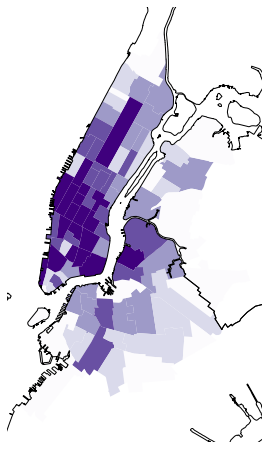

In [405]:
ax = cbDemand.plot(markersize=.1, figsize=(12, 8), column='count', cmap='Purples', scheme = 'quantiles')
plt.autoscale(False)
nyc.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

(-74.04107869371516, -73.88720750495658, 40.6286068710446, 40.88133241784448)

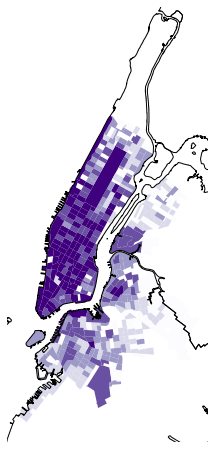

In [407]:
ax = cbDemandT.plot(markersize=.1, figsize=(12, 8), column='count', cmap='Purples', scheme = 'quantiles')
plt.autoscale(False)
nyc.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [367]:
#Save outputs as shapefile
cbDemand.to_file('cbDemand.shpe')
cbDemandT.to_file('cbDemandT.shpe')

## Taxi

In [109]:
def downloadTaxi(year, month, TaxiFolder):
    url = f'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv'
    save_to = TaxiFolder+ f'taxi_{year}-{month}.csv'
    urllib.request.urlretrieve(url, save_to)
    filename = f'taxi_{year}-{month}.csv'
    return filename

In [4]:
#Sample 3 months for the year
months = ['03', '06', '11']
years = ['2019']
files = []
for year in years:
    for month in months:
        files.append(downloadTaxi(year,month, TaxiFolder))
        

In [19]:
dtypes = {
'VendorID':                 int,
'tpep_pickup_datetime':     object,
'tpep_dropoff_datetime':    object,
'passenger_count':          int,
'trip_distance':            float,
'RatecodeID':               int,
'store_and_fwd_flag':       object,
'PULocationID':             int,
'DOLocationIDL':            int,
'payment_type':             int,
'fare_amount':              float,
'extra':                    float,
'mta_tax':                  float,
'tip_amount':               float,
'tolls_amount':             float,
'improvement_surcharge':    float,
'total_amount':             float,
'congestion_surcharge':     float
}

In [30]:
t1 =  pd.read_csv('Taxi/taxi_2019-03.csv')
t2 = pd.read_csv('Taxi/taxi_2019-06.csv')
t3 = pd.read_csv('Taxi/taxi_2019-11.csv')

In [32]:
taxi = pd.concat([t1, t2, t3])

In [33]:
taxi = taxi.drop_duplicates()
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['Date'] = taxi['tpep_pickup_datetime'].dt.date

In [332]:
%time taxidemand = taxi[['PULocationID','passenger_count']].groupby(['PULocationID'])\
.agg({'passenger_count':'sum' })

CPU times: user 519 ms, sys: 1.62 s, total: 2.14 s
Wall time: 3.86 s


In [333]:
taxidemand.head()

,passenger_count
PULocationID,
1,2093.0
2,5.0
3,399.0
4,42274.0
5,52.0


In [163]:
taxizones = gpd.read_file(TaxiFolder+'NYC Taxi Zones/geo_export_c86d362b-0930-4185-83d4-b9c1d5ee3bf6.shp')

In [164]:
taxizones.borough.unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn'],
      dtype=object)

In [165]:
excludezones = ['EWR', 'StatenIsland']

In [167]:
taxizones = taxizones.loc[(taxizones.borough.isin(excludezones)==False)]

In [336]:
taxipickups = pd.merge(taxizones, taxidemand,  left_on='location_i', right_on=taxidemand.index, how = 'left')

(-74.28337047811293, -73.67222994897456, 40.47514452607875, 40.936503646094195)

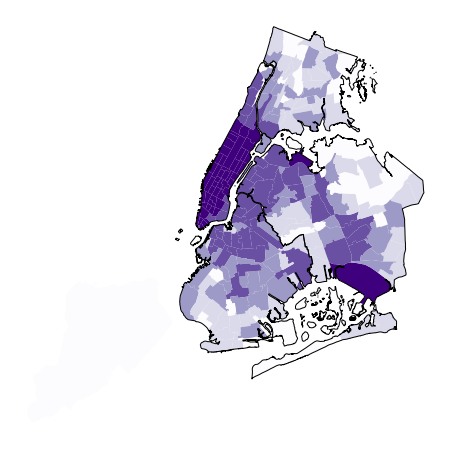

In [337]:
ax = taxipickups.plot(markersize=.1, figsize=(12, 8), column='passenger_count', cmap='Purples', scheme = 'quantiles')
plt.autoscale(False)
nyc.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [ ]:
taxipickups.to_file('taxidemand.shpe')

Now let's try looking at the paths between the centroids of the taxizones

In [225]:
taxipoints = gpd.GeoDataFrame({'zone':taxizones['location_i'],'geometry':(taxizones['geometry'].centroid)})


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [176]:
%time taxiOD= taxi[['PULocationID','DOLocationID','passenger_count']].groupby(['PULocationID','DOLocationID'], as_index=False)\
.agg({'passenger_count':'sum' })

CPU times: user 836 ms, sys: 390 ms, total: 1.23 s
Wall time: 1.28 s


In [219]:
taxiroutes = pd.merge(taxizones, taxiOD,  left_on='location_i', right_on='PULocationID', how = 'left')

In [220]:
taxiroutes['PUCenter'] = taxiroutes['PULocationID'].map(taxipoints['geometry'])
taxiroutes['DOCenter'] = taxiroutes['DOLocationID'].map(taxipoints['geometry'])

In [238]:
taxiroutes = taxiroutes.dropna(subset = ['DOCenter','PUCenter'])

In [239]:
taxiroutes

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,PULocationID,DOLocationID,passenger_count,PUCenter,DOCenter
0,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2.0,37.0,1.0,POINT (-73.84742 40.86447),POINT (-73.73555 40.69434)
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2.0,66.0,1.0,POINT (-73.84742 40.86447),POINT (-73.98570 40.70226)
2,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2.0,132.0,1.0,POINT (-73.84742 40.86447),POINT (-73.96817 40.79796)
3,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2.0,145.0,1.0,POINT (-73.84742 40.86447),POINT (-73.87363 40.77438)
4,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2.0,163.0,1.0,POINT (-73.84742 40.86447),POINT (-73.98516 40.74857)
...,...,...,...,...,...,...,...,...,...,...,...,...
38722,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",262.0,258.0,11.0,POINT (-73.94651 40.77593),POINT (-73.95990 40.71088)
38723,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",262.0,259.0,11.0,POINT (-73.94651 40.77593),POINT (-73.85222 40.89793)
38724,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",262.0,260.0,68.0,POINT (-73.94651 40.77593),POINT (-73.90631 40.74423)
38725,Manhattan,262.0,262.0,0.000122,0.049064,Yorkville East,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",262.0,261.0,421.0,POINT (-73.94651 40.77593),POINT (-74.01302 40.70914)


In [240]:
taxiroutesMn = taxiroutes.loc[(taxiroutes.borough=='Manhattan')].copy()
taxiroutesOuter = taxiroutes.loc[(taxiroutes.borough!='Manhattan')].copy()

In [255]:
taxiPopRoutesMn = taxiroutesMn.sort_values(by='passenger_count',ascending=False).head(50).copy()
taxiPopRoutesOuter = taxiroutesOuter.sort_values(by='passenger_count',ascending=False).head(50).copy()

In [256]:
geometryO = taxiPopRoutesMn.PUCenter
geometryD = taxiPopRoutesMn.DOCenter
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
taxiLinesMn = GeoDataFrame(taxiPopRoutesMn , crs='epsg:4326', geometry = geometry)

In [257]:
geometryO = taxiPopRoutesOuter.PUCenter
geometryD = taxiPopRoutesOuter.DOCenter
geometry = [LineString(od) for od in zip(geometryO,geometryD)]
taxiLinesOuter = GeoDataFrame(taxiPopRoutesOuter , crs='epsg:4326', geometry = geometry)

(-74.06511565581862, -73.68262303568324, 40.52314901967575, 40.934217716777425)

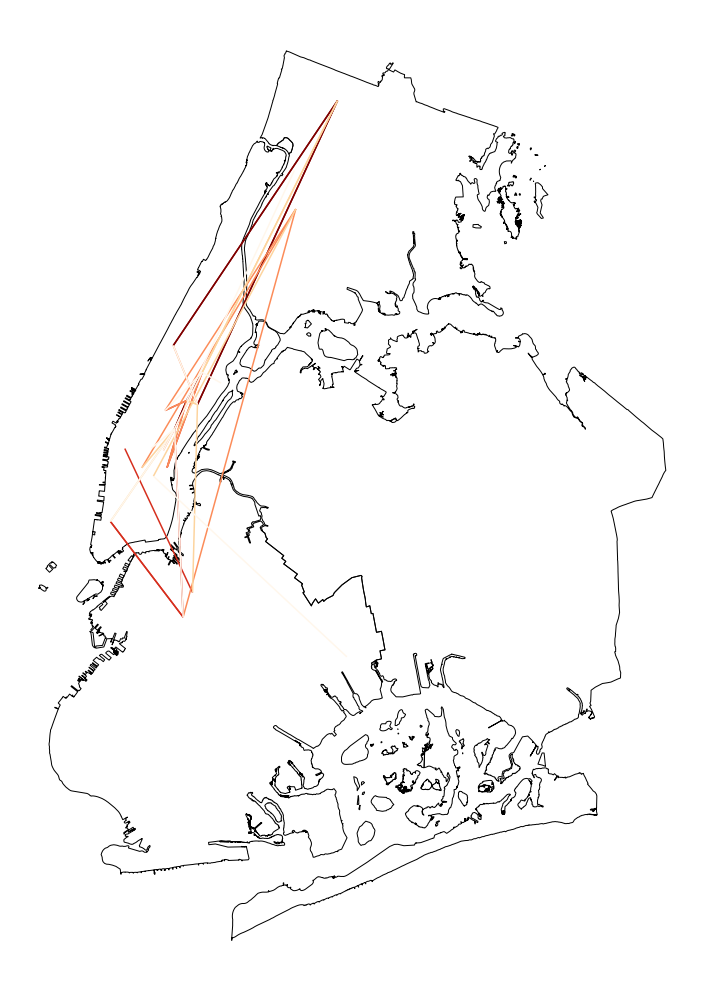

In [258]:
ax = taxiLinesMn.plot(markersize=.1, figsize=(18,18), column='passenger_count', cmap='OrRd', scheme = 'quantiles')
nyc.plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

(-74.09238921437405, -73.68132429479964, 40.52314901967575, 40.934217716777425)

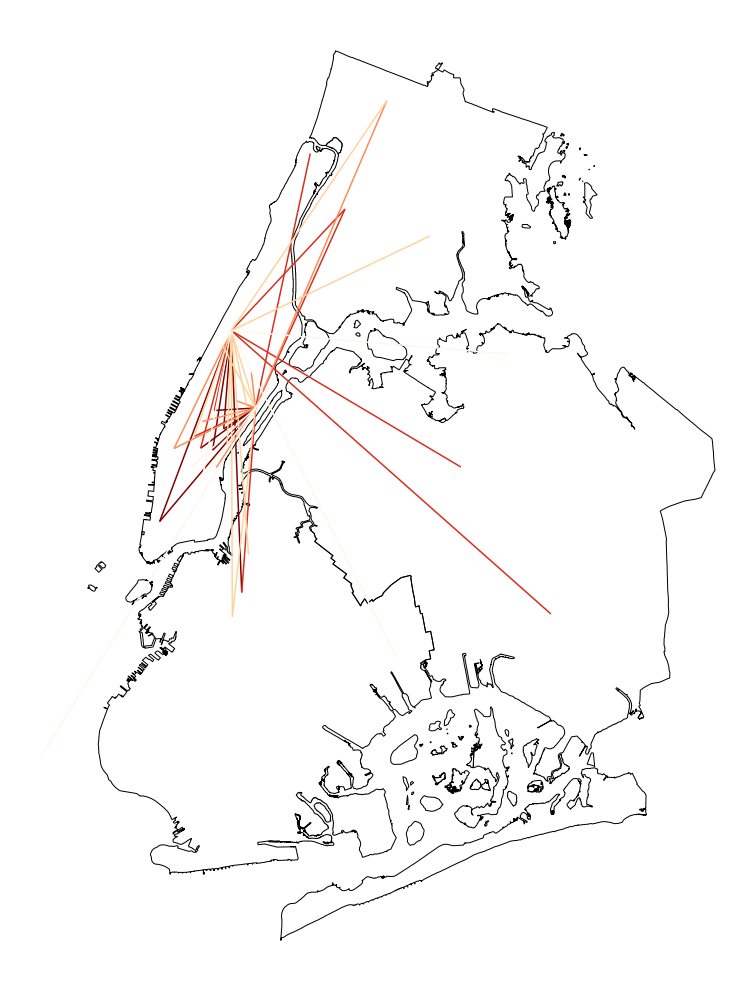

In [259]:
ax = taxiLinesOuter.plot(markersize=.1, figsize=(18,18), column='passenger_count', cmap='OrRd', scheme = 'quantiles')
nyc.plot(ax=ax, color='none',edgecolor='black')
ax.axis('off')

In [263]:
taxiLinesMn = taxiLinesMn[['borough',  'geometry', 'PULocationID', 'DOLocationID', 'passenger_count']].copy()
taxiLinesOuter = taxiLinesOuter[['borough',  'geometry', 'PULocationID', 'DOLocationID', 'passenger_count']].copy()


In [264]:
taxiLinesMn.to_file('taxiLinesMn.shpe')
taxiLinesOuter.to_file('taxiLinesOuter.shpe')

## Total Subway Entries per Zone

Note: some cleaning and aggregating in this section adapted from https://www.kaggle.com/nieyuqi/mta-turnstile-data-analysis

In [267]:
df200104 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200104.txt')
print('df200104 is uploaded')
df200111 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200111.txt')
print('df200111 is uploaded')
df200118 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200118.txt')
print('df200118 is uploaded')
df200125 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200125.txt')
print('df200125 is uploaded')

df200104 is uploaded
df200111 is uploaded
df200118 is uploaded
df200125 is uploaded


In [276]:
turnstiles = pd.concat([df200104, df200111, df200118, df200125])
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,03:00:00,REGULAR,7324295,2482512
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,07:00:00,REGULAR,7324305,2482523
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,11:00:00,REGULAR,7324371,2482594
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,15:00:00,REGULAR,7324587,2482647
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,19:00:00,REGULAR,7324963,2482713


In [270]:
complexes = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [278]:
mta = turnstiles[['C/A','UNIT','SCP','STATION','DATE','TIME','DESC','ENTRIES','EXITS                                                               ','LINENAME','DIVISION']].copy()
mta.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,LINENAME,DIVISION
0,A002,R051,02-00-00,59 ST,12/28/2019,03:00:00,REGULAR,7324295,2482512,NQR456W,BMT
1,A002,R051,02-00-00,59 ST,12/28/2019,07:00:00,REGULAR,7324305,2482523,NQR456W,BMT
2,A002,R051,02-00-00,59 ST,12/28/2019,11:00:00,REGULAR,7324371,2482594,NQR456W,BMT
3,A002,R051,02-00-00,59 ST,12/28/2019,15:00:00,REGULAR,7324587,2482647,NQR456W,BMT
4,A002,R051,02-00-00,59 ST,12/28/2019,19:00:00,REGULAR,7324963,2482713,NQR456W,BMT


In [279]:
mta.columns =['C/A','unit','SCP','Station','date','time','desc','entries','exits','linename','division']  

In [280]:
#create new cols for datetime and unique turnstile identifier
mta['datetime'] = pd.to_datetime(mta.date + ' ' + mta.time, format='%m/%d/%Y  %H:%M:%S')
mta['turnstile'] = mta['C/A'] + '-' + mta['unit'] + '-' + mta['SCP']


In [281]:
# group data by turnstile, sort each turnstile by datetime
# Create new columns en_diff and ex_diff for each unique turnstile
# turn cumulative counts into counts per interval

mta_sorted = mta.sort_values(['turnstile', 'datetime'])
mta_sorted = mta_sorted.reset_index(drop = True)

turnstile_grouped = mta_sorted.groupby(['turnstile'])

mta_sorted['entries_diff'] = turnstile_grouped['entries'].transform(pd.Series.diff)
mta_sorted['exits_diff'] = turnstile_grouped['exits'].transform(pd.Series.diff)

mta_sorted.head()

,C/A,unit,SCP,Station,date,time,desc,entries,exits,linename,division,datetime,turnstile,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,12/28/2019,03:00:00,REGULAR,7324295,2482512,NQR456W,BMT,2019-12-28 03:00:00,A002-R051-02-00-00,NaN,NaN
1,A002,R051,02-00-00,59 ST,12/28/2019,07:00:00,REGULAR,7324305,2482523,NQR456W,BMT,2019-12-28 07:00:00,A002-R051-02-00-00,10.0,11.0
2,A002,R051,02-00-00,59 ST,12/28/2019,11:00:00,REGULAR,7324371,2482594,NQR456W,BMT,2019-12-28 11:00:00,A002-R051-02-00-00,66.0,71.0
3,A002,R051,02-00-00,59 ST,12/28/2019,15:00:00,REGULAR,7324587,2482647,NQR456W,BMT,2019-12-28 15:00:00,A002-R051-02-00-00,216.0,53.0
4,A002,R051,02-00-00,59 ST,12/28/2019,19:00:00,REGULAR,7324963,2482713,NQR456W,BMT,2019-12-28 19:00:00,A002-R051-02-00-00,376.0,66.0


In [284]:
mta_sorted['entries_diff'] = mta_sorted['entries_diff'].fillna(0).copy()
mta_sorted['exits_diff'] = mta_sorted['exits_diff'].fillna(0).copy()

mta_sorted['entries_diff'][mta_sorted['entries_diff'] < 0] = 0 
mta_sorted['exits_diff'][mta_sorted['exits_diff'] < 0] = 0 

mta_sorted['entries_diff'][mta_sorted['entries_diff'] >= 6000] = 0 
mta_sorted['exits_diff'][mta_sorted['exits_diff'] >= 6000] = 0

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Applications/ana

In [411]:
##Data source here: https://github.com/tsdataclinic/mta/tree/master/data/crosswalk
xref = pd.read_csv('Master_crosswalk.csv')
xref.head()

,station_name,clean_lines,station_lines,el_station_name,el_lines,equipments,gtfs_station_name,gtfs_lines,turnstile_station_name,turnstile_lines,gtfs_stop_id,lat,lon,turnstile_units
0,Astor Pl,46,4-6-6 Express,NaN,NaN,NaN,Astor Pl,"4,6,6X",ASTOR PL,6,636,40.730054,-73.99107,R160
1,Canal St,46,4-6-6 Express,Canal St,6,"EL324,EL325",Canal St,"4,6,6X",CANAL ST,JNQRZ6W,639,40.718803,-74.00019300000001,"R118,R462,R463"
2,50th St,12,1-2,NaN,NaN,NaN,50 St,"1,2",50 ST,1,126,40.761728,-73.98384899999999,R116
3,Bergen St,234,2-3-4,NaN,NaN,NaN,Bergen St,"2,3,4",BERGEN ST,23,236,40.680829,-73.975098,R058
4,Pennsylvania Ave,34,3-4,NaN,NaN,NaN,Pennsylvania Av,"2,3,4,5",PENNSYLVANIA AV,3,255,40.664635,-73.89489499999999,R067


In [286]:
mta_stations = pd.merge(mta_sorted, xref, left_on= 'Station', right_on = 'turnstile_station_name')

In [287]:
mta_stations = mta_stations[['Station', 'date', 'time', 'desc', 'linename', 'datetime', 'turnstile',
       'entries_diff', 'exits_diff', 'station_name', 'clean_lines',
       'station_lines', 'equipments', 'turnstile_station_name',
       'turnstile_lines', 'gtfs_stop_id', 'lat', 'lon', 'turnstile_units']].copy()
mta_stations['DOW'] = mta_stations['datetime'].dt.weekday
mta_stations.head()

,Station,date,time,desc,linename,datetime,turnstile,entries_diff,exits_diff,station_name,clean_lines,station_lines,equipments,turnstile_station_name,turnstile_lines,gtfs_stop_id,lat,lon,turnstile_units,DOW
0,59 ST,12/28/2019,03:00:00,REGULAR,NQR456W,2019-12-28 03:00:00,A002-R051-02-00-00,0.0,0.0,Lexington Ave - 59th St,NRW,N-R-W,"ES249,ES248,ES215",59 ST,456NQRW,R11,40.762660,-73.967258,"R050,R051",5
1,59 ST,12/28/2019,03:00:00,REGULAR,NQR456W,2019-12-28 03:00:00,A002-R051-02-00-00,0.0,0.0,Lexington Ave - 59th St,NRW,N-R-W,"ES249,ES248,ES215",59 ST,NQR456W,R11,40.762660,-73.967258,"R050,R051",5
2,59 ST,12/28/2019,03:00:00,REGULAR,NQR456W,2019-12-28 03:00:00,A002-R051-02-00-00,0.0,0.0,Lexington Ave - 59th St,NRW,N-R-W,"ES249,ES248,ES215",59 ST,NRW,R11,40.762660,-73.967258,"R050,R051",5
3,59 ST,12/28/2019,03:00:00,REGULAR,NQR456W,2019-12-28 03:00:00,A002-R051-02-00-00,0.0,0.0,59th St,NR,N-R,NaN,59 ST,456NQRW,R41,40.641362,-74.017881,"R050,R051",5
4,59 ST,12/28/2019,03:00:00,REGULAR,NQR456W,2019-12-28 03:00:00,A002-R051-02-00-00,0.0,0.0,Lexington Ave - 59th St,456,4-5-6-6 Express,"ES213,ES211,ES214,ES212",59 ST,456NQRW,629,40.762526,-73.967967,"R050,R051",5


In [288]:
mta_stations['lat'] = pd.to_numeric(mta_stations['lat'], errors='coerce')
mta_stations['lon'] = pd.to_numeric(mta_stations['lon'], errors='coerce')
mta_stations['lat']= mta_stations['lat'].round(decimals=5)
mta_stations['lon']= mta_stations['lon'].round(decimals=5)


In [293]:
mtaAgg = mta_stations[['lat','lon','entries_diff','exits_diff']].groupby(['lat','lon'], as_index=False).sum()

mtaAgg.columns = ['lat','lon','entries','exits']
mtaAgg.head(10)

,lat,lon,entries,exits
0,40.57613,-73.97594,50002.0,35184.0
1,40.57631,-73.96850,68300.0,27087.0
2,40.57742,-73.98123,520096.0,452444.0
3,40.57762,-73.96138,248555.0,145531.0
4,40.58090,-73.83559,14268.0,17439.0
5,40.58101,-73.97457,30088.0,11878.0
6,40.58321,-73.82756,4344.0,5794.0
7,40.58531,-73.82056,9235.0,9849.0
8,40.58690,-73.95416,295613.0,271890.0
9,40.58803,-73.81364,16911.0,16112.0


In [311]:
geometry = [Point(xy) for xy in zip(mtaAgg.lon, mtaAgg.lat)]

mtaGeo = GeoDataFrame(mtaAgg, crs="EPSG:4326", geometry=geometry)


In [298]:
mtaGeo = gpd.sjoin(tracts, mtaGeo, op='intersects', how='inner').copy()

In [312]:
mtaGeo = gpd.sjoin(taxizones, mtaGeo, op='intersects', how='inner').copy()

In [313]:
subwaydemand = mtaGeo.groupby(['location_i'])\
.agg({'entries':'sum','borough':'first','geometry':'first'}).copy()

In [301]:
subwaydemand = mtaGeo.groupby(['TractID'])\
.agg({'entries':'sum','geometry':'first', 'PUMA':'first'}).copy()

In [309]:
taxizones

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
5,Staten Island,6.0,6.0,0.000606,0.150491,Arrochar/Fort Wadsworth,"POLYGON ((-74.06367 40.60220, -74.06351 40.602..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [ ]:
subwaydemand = mtaGeo.groupby(['TractID','BOROCODE'])\
.agg({'entries':'sum','geometry':'first', 'PUMA':'first'}).copy()

In [315]:
subwaydemand = gpd.GeoDataFrame(subwaydemand, crs='epsg:4326', geometry = subwaydemand['geometry'])

(-74.05710941365759, -73.72242381200451, 40.54961782798635, 40.92763213982116)

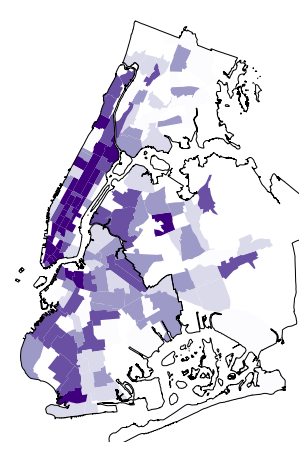

In [372]:
ax = subwaydemand.plot(markersize=.1, figsize=(12, 8), column='entries', cmap='Purples', scheme = 'quantiles')
plt.autoscale(False)
nyc.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [ ]:
subwaydemand.to_file('subwayentries.shpe')